In [ ]:
# source: https://pennylane.ai/qml/demos/tutorial_kernels_module/
# evaluate kernels, use them for classification and train them with gradient-based optimization
# only for training full data on PRETRAINED parameters (for full code, including training parameters go to embed_qkernel_orig)

In [28]:
from pennylane import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC

In [29]:
# LOAD DATA 
X = np.loadtxt("trainX.txt")
Y = np.loadtxt("trainY.txt")

Training the Quantum Embedding Kernel
===================================

PennyLane\'s [kernels
module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html)
allows for a particularly simple implementation of Quantum Embedding
Kernels. The first ingredient we need for this is an *ansatz*, which we
will construct by repeating a layer as building block. Let\'s start by
defining this layer:


In [30]:
import pennylane as qml

def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0][j], wires=[wire])
        # qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])
    # qml.broadcast(unitary=qml.CRZ, pattern="chain", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

In [31]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0] # kernel value = probabality of |000> (all-zero state)

In [32]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

In [ ]:
import time
start = time.time()

# paramters from size 400, 5 qubits
init_params = [[[ 4.43579632,  5.95588264,  1.97631895,  1.7118079,  4.64243166], [ 5.50426713,  2.25842913,  4.31622265,  0.10696863,  5.47067019]],
[[ 1.01553446,  4.37445215,  3.74262481,  4.86624659,  2.81187996], [ 0.60648683,  4.74618443,  1.9680156,  5.82452492,  4.46579975]],
[[ 1.28841508,  4.34824804,  5.53368509,  2.15002838,  4.37367301], [ 0.11758295,  2.6847685,  3.17758759,  5.07467742,  5.32711511]],
[[ 6.56351428,  5.58980198,  1.12458044,  1.20459353, -0.14599216], [ 0.92603956,  4.32338889,  0.3925044,  2.44958368,  1.02926268]],
[[ 2.95973522,  0.99847921,  0.63422612,  5.20947467,  6.15839107], [ 5.1472463,  3.34834323,  4.06946024,  3.27777642,  5.70657485]],
[[ 5.72153431,  2.16144867,  2.11998269,  0.52948446,  5.45257038], [ 5.84396771,  0.43399747,  6.21551017,  0.88154949,  5.41424268]]]

init_kernel = lambda x1, x2: kernel(x1, x2, init_params)

svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

accuracy_init = accuracy(svm, X, Y)
print(f"The training accuracy of the kernel with pre-trained parameters on the full data is {accuracy_init:.3f}")

end = time.time()
print("runtime in min: ", (end-start)/60)

In [ ]:
# PRINT MATRIX
# K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)
# with np.printoptions(precision=3, suppress=True):
#     print(K_init)

In [27]:
start = time.time()

# TEST DATA ACCURACY
Xtest = np.loadtxt("testX.txt")
Ytest = np.loadtxt("testY.txt")
accuracy_test = accuracy(svm, Xtest, Ytest)
print(f"The testing accuracy of a kernel with trained parameters is {accuracy_test:.3f}")

end = time.time()
print("runtime in min: ", (end-start)/60)

The testing accuracy of a kernel with trained parameters is 0.934


In [22]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

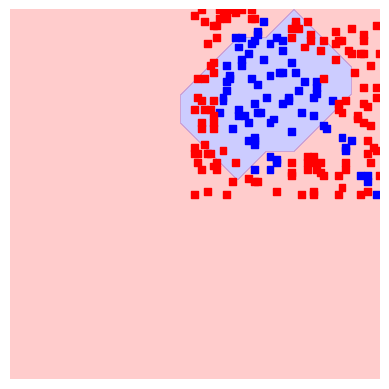

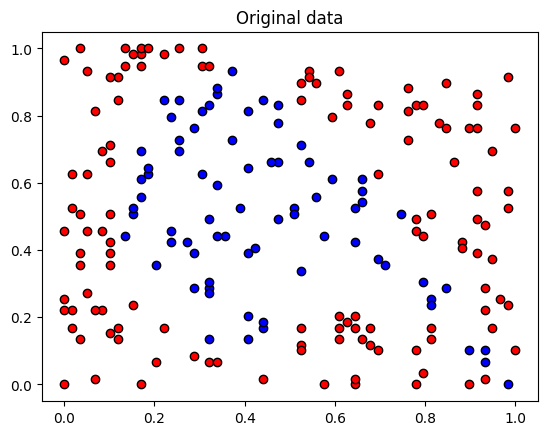

In [88]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == 0], X[:, 1][Y == 0], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

In [ ]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())